In [1]:
import numpy as np
import torch
import json
import torch.nn.functional as F

In [2]:

import sys
import os

def add_path(path):
    if path not in sys.path:
        sys.path.insert(-1, path)

add_path(os.path.join(sys.path[0], '../')) 
print("add code root path (with `mylib`).") 

from utils import rend_util

add code root path (with `mylib`).


In [3]:
a = np.zeros((10, 10))
b = np.array([[1,2], [5,5], [8,8]])

a[b[:,0], b[:,1]] = 1

In [8]:
uv = np.mgrid[0:512, 0:512].astype(np.int32)

print(uv)
uv = torch.from_numpy(np.flip(uv, axis=0).copy()).float()

print(uv)
# uv = uv.reshape(2, -1).transpose(1, 0)

[[[  0   0   0 ...   0   0   0]
  [  1   1   1 ...   1   1   1]
  [  2   2   2 ...   2   2   2]
  ...
  [509 509 509 ... 509 509 509]
  [510 510 510 ... 510 510 510]
  [511 511 511 ... 511 511 511]]

 [[  0   1   2 ... 509 510 511]
  [  0   1   2 ... 509 510 511]
  [  0   1   2 ... 509 510 511]
  ...
  [  0   1   2 ... 509 510 511]
  [  0   1   2 ... 509 510 511]
  [  0   1   2 ... 509 510 511]]]
tensor([[[  0.,   1.,   2.,  ..., 509., 510., 511.],
         [  0.,   1.,   2.,  ..., 509., 510., 511.],
         [  0.,   1.,   2.,  ..., 509., 510., 511.],
         ...,
         [  0.,   1.,   2.,  ..., 509., 510., 511.],
         [  0.,   1.,   2.,  ..., 509., 510., 511.],
         [  0.,   1.,   2.,  ..., 509., 510., 511.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
         [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
         ...,
         [509., 509., 509.,  ..., 509., 509., 509.],
         [510., 510., 510.,  ..., 510., 

In [11]:
uv = uv.reshape(2, -1).transpose(1, 0)

In [12]:
uv.shape

torch.Size([262144, 2])

In [6]:
uv

tensor([[  0.,   0.],
        [  1.,   0.],
        [  2.,   0.],
        ...,
        [509., 511.],
        [510., 511.],
        [511., 511.]])

In [41]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [42]:
b = np.transpose(a)[:,::-1]

In [43]:
b

array([[7, 4, 1],
       [8, 5, 2],
       [9, 6, 3]])

In [38]:
np.flip(b)

array([[9, 6, 3],
       [8, 5, 2],
       [7, 4, 1]])

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"]='6'

In [16]:
img_res = [256, 256]


uv = np.mgrid[0:img_res[0], 0:img_res[1]].astype(np.int32)
uv = torch.from_numpy(np.flip(uv, axis=0).copy()).float()
uv = uv.reshape(2, -1).transpose(1, 0)

In [17]:
uv = uv.unsqueeze(0).cuda()

In [18]:
uv

tensor([[[  0.,   0.],
         [  1.,   0.],
         [  2.,   0.],
         ...,
         [253., 255.],
         [254., 255.],
         [255., 255.]]], device='cuda:0')

In [7]:
batch_size, num_samples, _ = uv.shape

In [8]:
def lift(x, y, z, intrinsics):
    # parse intrinsics
    intrinsics = intrinsics.cuda()
    fx = intrinsics[:, 0, 0]
    fy = intrinsics[:, 1, 1]
    cx = intrinsics[:, 0, 2]
    cy = intrinsics[:, 1, 2]
    sk = intrinsics[:, 0, 1]

    x_lift = (x - cx.unsqueeze(-1) + cy.unsqueeze(-1)*sk.unsqueeze(-1)/fy.unsqueeze(-1) - sk.unsqueeze(-1)*y/fy.unsqueeze(-1)) / fx.unsqueeze(-1) * z
    y_lift = (y - cy.unsqueeze(-1)) / fy.unsqueeze(-1) * z

    # homogeneous
    return torch.stack((x_lift, y_lift, z, torch.ones_like(z)), dim=-1)


def read_cam_dict(cam_dict_file):
    with open(cam_dict_file) as fp:
        cam_dict = json.load(fp)
        for x in sorted(cam_dict.keys()):
            K = np.array(cam_dict[x]['K']).reshape((4, 4))
            W2C = np.array(cam_dict[x]['W2C']).reshape((4, 4))
            C2W = np.linalg.inv(W2C)

            cam_dict[x]['K'] = K
            cam_dict[x]['W2C'] = W2C
            cam_dict[x]['C2W'] = C2W
    return cam_dict


In [9]:
cam_dict_file = '/data1/sr/code/PhySG/example_data/kitty/finetune_data/cam_dict_norm.json'
cam_dict = read_cam_dict(cam_dict_file)
intrinsics = torch.from_numpy(cam_dict['rgb_000100.exr']['K'].astype(np.float32)).unsqueeze(0).cuda()
pose = torch.from_numpy(cam_dict['rgb_000100.exr']['C2W'].astype(np.float32)).unsqueeze(0).cuda()

object_mask = torch.ones((512*512, )).bool()

# object_mask = rend_util.load_mask('')
# print('Loaded mask: ', path)
# object_mask = object_mask.reshape(-1)
# self.object_masks.append(torch.from_numpy(object_mask).bool())


if pose.shape[1] == 7: #In case of quaternion vector representation
    cam_loc = pose[:, 4:]
    R = quat_to_rot(pose[:,:4])
    p = torch.eye(4).repeat(pose.shape[0],1,1).cuda().float()
    p[:, :3, :3] = R
    p[:, :3, 3] = cam_loc
else: # In case of pose matrix representation
    cam_loc = pose[:, :3, 3]
    p = pose

batch_size, num_samples, _ = uv.shape


depth = torch.ones((batch_size, num_samples)).cuda()
x_cam = uv[:, :, 0].view(batch_size, -1)
y_cam = uv[:, :, 1].view(batch_size, -1)
z_cam = depth.view(batch_size, -1)

pixel_points_cam = lift(x_cam, y_cam, z_cam, intrinsics=intrinsics)

# permute for batch matrix product
pixel_points_cam = pixel_points_cam.permute(0, 2, 1)

world_coords = torch.bmm(p, pixel_points_cam).permute(0, 2, 1)[:, :, :3]
ray_dirs = world_coords - cam_loc[:, None, :]
ray_dirs_norm = F.normalize(ray_dirs, dim=2)

In [10]:
uv.dtype, edited_pixel_coords

NameError: name 'edited_pixel_coords' is not defined

In [ ]:
edited_pixel_coords_0 = torch.tensor(edited_pixel_coords.astype(np.float32)).cuda()
uv_0 = uv.squeeze(0)

uv_0.shape, edited_pixel_coords_0.shape

(torch.Size([65536, 2]), torch.Size([4, 2]))

In [11]:
m = (uv_0[:, None] == edited_pixel_coords_0).all(-1).any(1)

NameError: name 'uv_0' is not defined

In [12]:
if edited_pixel_coords_0.shape[0] == 0:
    m = torch.tensor([False, ]*uv_0.shape[0]).bool().cuda()

NameError: name 'edited_pixel_coords_0' is not defined

In [13]:
m0 = torch.tensor([False, ]*uv_0.shape[0]).bool().cuda()

NameError: name 'uv_0' is not defined

In [14]:
m.dtype, m.shape

NameError: name 'm' is not defined

In [15]:
m0.shape

NameError: name 'm0' is not defined

In [16]:
unedited_pixels_idx = np.argwhere(m.cpu().numpy()==False).squeeze(-1)

unedited_pixels_idx = torch.tensor(unedited_pixels_idx).cuda()

unedited_pixels_coords = torch.index_select(uv, dim=1, index=unedited_pixels_idx)

print(unedited_pixels_idx, unedited_pixels_coords)

NameError: name 'm' is not defined

In [17]:
edited_pixels_idx = np.argwhere(m.cpu().numpy()==True).squeeze(-1)

edited_pixels_idx = torch.tensor(edited_pixels_idx).cuda()

edited_pixels_coords = torch.index_select(uv, dim=1, index=edited_pixels_idx)

print(edited_pixels_idx, edited_pixels_coords)

NameError: name 'm' is not defined

In [18]:
edited_pixels_idx

NameError: name 'edited_pixels_idx' is not defined

In [19]:
a = torch.ones((300,3))
b = torch.zeros((4,3))
a.shape


torch.Size([300, 3])

In [20]:
a[edited_pixels_idx] = b

NameError: name 'edited_pixels_idx' is not defined

In [21]:
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1

In [22]:
idx = np.argwhere(m.cpu().numpy())

idx = idx.squeeze(-1)

NameError: name 'm' is not defined

In [23]:
idx = np.argwhere(m.cpu().numpy())

idx = idx.squeeze(-1)

idx = torch.tensor(idx).cuda()


torch.index_select(uv, dim=1, index=idx)

NameError: name 'm' is not defined

In [24]:
uv_0[m].shape

NameError: name 'uv_0' is not defined

In [25]:
uv.squeeze(0).shape

torch.Size([65536, 2])

In [26]:
test = torch.tensor([])
a = uv.squeeze(0)[0].unsqueeze(0).cpu()
b = uv.squeeze(0)[1].unsqueeze(0).cpu()

In [27]:
a, b, a.shape

(tensor([[0., 0.]]), tensor([[1., 0.]]), torch.Size([1, 2]))

In [28]:
test = torch.cat((test,a), dim=0)
test

tensor([[0., 0.]])

In [29]:
test = torch.cat((test,b), dim=0)
test

tensor([[0., 0.],
        [1., 0.]])

In [30]:
test.shape

torch.Size([2, 2])

In [31]:
pixel_points_cam.shape

torch.Size([1, 4, 65536])

In [32]:
world_coords[:,:,2]

tensor([[-0.2896, -0.2891, -0.2886,  ..., -0.4447, -0.4443, -0.4438]],
       device='cuda:0')

In [33]:
pixel_points_cam.squeeze(0)

tensor([[-0.3153, -0.3141, -0.3128,  ..., -0.0037, -0.0025, -0.0012],
        [-0.3153, -0.3153, -0.3153,  ..., -0.0012, -0.0012, -0.0012],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
       device='cuda:0')

In [34]:
pixel_points_cam[:,:,2]

tensor([[-0.3128, -0.3153,  1.0000,  1.0000]], device='cuda:0')

In [35]:
ray_dirs, ray_dirs_norm

(tensor([[[ 0.5351, -0.8265,  0.4789],
          [ 0.5340, -0.8265,  0.4794],
          [ 0.5328, -0.8265,  0.4799],
          ...,
          [ 0.1356, -0.9364,  0.3237],
          [ 0.1345, -0.9364,  0.3242],
          [ 0.1333, -0.9364,  0.3247]]], device='cuda:0'),
 tensor([[[ 0.4887, -0.7549,  0.4374],
          [ 0.4878, -0.7551,  0.4380],
          [ 0.4870, -0.7554,  0.4385],
          ...,
          [ 0.1356, -0.9364,  0.3237],
          [ 0.1345, -0.9364,  0.3242],
          [ 0.1333, -0.9364,  0.3247]]], device='cuda:0'))

In [36]:
print(ray_dirs_norm.shape)
idx = torch.tensor([0,1,2])

torch.index_select(ray_dirs_norm.cpu(), dim=1, index=idx)

torch.Size([1, 65536, 3])


tensor([[[ 0.4887, -0.7549,  0.4374],
         [ 0.4878, -0.7551,  0.4380],
         [ 0.4870, -0.7554,  0.4385]]])

In [37]:
points_a = torch.rand((1,4,3))
points_b = torch.rand((1,4,3))
points_a, points_b

dist = torch.sum((points_a-points_b)**2, dim=-1).squeeze(0)
dist, dist.shape

(tensor([0.6839, 0.8643, 0.9617, 0.3302]), torch.Size([4]))

In [38]:
idx = np.argwhere(dist<0.5)

idx

tensor([[3]])

In [39]:
a = torch.tensor([[1,1], [2,2]])
b = torch.tensor([[1,3], [12,1]])

In [40]:
(a-b)

tensor([[  0,  -2],
        [-10,   1]])

In [41]:
torch.sum((a-b)**2, dim=-1)

tensor([  4, 101])

In [42]:
idx.shape

torch.Size([1, 1])

In [43]:
p.shape, torch.inverse(p)

(torch.Size([1, 4, 4]),
 tensor([[[-9.2635e-01,  6.2160e-09,  3.7666e-01, -4.7461e-09],
          [-3.5286e-01, -3.4983e-01, -8.6782e-01, -9.8372e-08],
          [ 1.3177e-01, -9.3681e-01,  3.2407e-01,  2.3714e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
        device='cuda:0'))

In [44]:
torch.bmm(p, torch.inverse(p))

tensor([[[ 1.0000e+00, -8.6079e-10, -8.7354e-09,  0.0000e+00],
         [ 2.0146e-08,  1.0000e+00,  3.8201e-08,  2.3842e-07],
         [-9.6374e-09, -2.0458e-10,  1.0000e+00,  5.9605e-08],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')

In [45]:
torch.bmm(p, pixel_points_cam).permute((0,2,1))[:,:,-1], world_coords.shape

(tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0'),
 torch.Size([1, 65536, 3]))

In [46]:
a, b, c = world_coords.shape
new_world_coords = torch.ones(a,b,c+1)
new_world_coords[:,:,:3] = world_coords
new_world_coords = new_world_coords.permute(0,2,1).cuda()

In [47]:
pixel = torch.bmm(torch.inverse(p), new_world_coords)

In [48]:
pixel, pixel_points_cam

(tensor([[[-0.3153, -0.3141, -0.3128,  ..., -0.0037, -0.0025, -0.0012],
          [-0.3153, -0.3153, -0.3153,  ..., -0.0012, -0.0012, -0.0012],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]],
        device='cuda:0'),
 tensor([[[-0.3153, -0.3141, -0.3128,  ..., -0.0037, -0.0025, -0.0012],
          [-0.3153, -0.3153, -0.3153,  ..., -0.0012, -0.0012, -0.0012],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]],
        device='cuda:0'))

In [49]:
pixel = pixel.squeeze(0)

x, y, z = pixel[:3, 0]

In [50]:
x, y, z

(tensor(-0.3153, device='cuda:0'),
 tensor(-0.3153, device='cuda:0'),
 tensor(1.0000, device='cuda:0'))

In [51]:
a = np.array([-0.34213213]).astype(np.float16)

In [52]:
a

array([-0.342], dtype=float16)

In [53]:
pixel_points_cam.shape

torch.Size([1, 4, 65536])

In [54]:
# x_norm, y_norm = x/z, y/z

In [55]:
from bisect import bisect_left, bisect_right

def get_pixel_coords(x, y, pixels, resolution=256):
    vals = list(np.unique(pixels[0].cpu().numpy().astype(np.float16)))
    # print(vals, len(vals))
    x_coor = bisect_left(vals, x)
    y_coor = bisect_left(vals, y)

    return np.array([[x_coor-1, y_coor-1], [x_coor, y_coor-1], [x_coor-1, y_coor], [x_coor, y_coor]])


In [56]:
edited_pixel_coords = get_pixel_coords(-0.3148, -0.3148, pixel_points_cam.squeeze(0))

In [58]:
edited_pixel_coords

array([[0, 0],
       [1, 0],
       [0, 1],
       [1, 1]])

In [57]:
pixel_points_cam.squeeze(0)

tensor([[-0.3153, -0.3141, -0.3128,  ..., -0.0037, -0.0025, -0.0012],
        [-0.3153, -0.3153, -0.3153,  ..., -0.0012, -0.0012, -0.0012],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
       device='cuda:0')

In [204]:
pixel_points_cam = lift(x_cam[-6:], y_cam[-6:], z_cam[-6:], intrinsics=intrinsics)
We show rendering examples of NeuTex [59], NeuS [55] and our method on
the DTU dataset and the NeRF 360◦ Synthetic dataset.
pixel_points_cam = pixel_points_cam.permute(0, 2, 1)

world_coords = torch.bmm(p, pixel_points_cam).permute(0, 2, 1)[:, :, :3]#.cuda()
ray_dirs0 = world_coords - cam_loc[:, None, :]
ray_dirs0_norm = F.normalize(ray_dirs0, dim=2)

In [205]:
(ray_dirs0 == ray_dirs[-6:]).all()

tensor(True, device='cuda:0')

In [206]:
(ray_dirs0_norm == ray_dirs_norm[-6:]).all()

tensor(True, device='cuda:0')

In [207]:
from model.ray_tracing import RayTracing
from model.implicit_differentiable_renderer_v3 import ImplicitNetwork

from pyhocon import ConfigFactory

conf = ConfigFactory.parse_file('../confs_sg/default.conf').get_config('model')

In [208]:
ray_tracer = RayTracing(**conf.get_config('ray_tracer'))

implicit_network = ImplicitNetwork(conf.get_int('feature_vector_size'), **conf.get_config('implicit_network'))

implicit_network.cuda().eval()

ImplicitNetowork feature_vector_size:  0


ImplicitNetwork(
  (lin0): Linear(in_features=39, out_features=512, bias=True)
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=473, bias=True)
  (lin4): Linear(in_features=512, out_features=512, bias=True)
  (lin5): Linear(in_features=512, out_features=512, bias=True)
  (lin6): Linear(in_features=512, out_features=512, bias=True)
  (lin7): Linear(in_features=512, out_features=512, bias=True)
  (lin8): Linear(in_features=512, out_features=1, bias=True)
  (softplus): Softplus(beta=100, threshold=20)
)

In [209]:
with torch.no_grad():
    points, network_object_mask, dists = ray_tracer(sdf=lambda x: implicit_network(x)[:, 0],
                                                    cam_loc=cam_loc,
                                                    object_mask=object_mask,
                                                    ray_directions=ray_dirs0_norm)

IndexError: The shape of the mask [65536] at index 0does not match the shape of the indexed tensor [262144] at index 0

In [97]:
import PIL
from PIL import Image

# edited_image = Image.open('/data1/sr/code/PhySG/cvpr23//data/color_editing/kitty/color_painting.jpg').resize((512, 512),resample=PIL.Image.BILINEAR)

# edited_image.save('/data1/sr/code/PhySG/cvpr23//data/color_editing/kitty/resized/color_painting.jpg')


mask_image = Image.open('/data1/sr/code/PhySG/cvpr23/data/color_editing/chair/shape09135_rank02/edited/mask.png').resize((256, 256),resample=PIL.Image.BILINEAR)

# mask_image.save('/data1/sr/code/PhySG/cvpr23//data/color_editing/kitty/mask_0.jpg', cmap='gray')

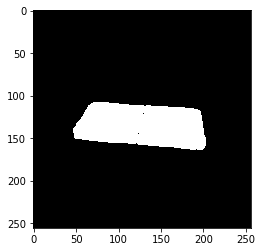

In [99]:
ones = np.ones_like(mask_image)
zeros = np.zeros_like(mask_image)

bg = ones * 255.

# edited_area = np.equal(np.equal(mask_image, bg), False).astype(np.uint8) * 255

edited_area = np.where(np.equal(mask_image, bg), zeros, ones).astype(np.uint8)[:,:,0] * 255

# edited_area = np.equal(mask_image, bg).astype(np.uint8) * 255

from skimage.morphology import dilation, erosion, disk, closing, opening


kernel = disk(1)
edited_area = opening(edited_area, kernel)

# kernel = disk(1)
# closed_edited_area = closing(closed_edited_area, kernel)

# kernel = disk(6)
# closed_edited_area = closing(closed_edited_area, kernel)


import matplotlib.pyplot as plt
plt.imshow(edited_area, cmap='gray')

# import matplotlib.pyplot as plt
# plt.imshow(edited_area, cmap='gray')


edited_area = Image.fromarray(edited_area)

edited_area.save('/data1/sr/code/PhySG/cvpr23/data/color_editing/chair/shape09135_rank02/edited/mask_0.jpg', cmap='gray')

In [10]:
import imageio

In [59]:
edited_image = imageio.imread('/data1/sr/code/PhySG/cvpr23//data/color_editing/kitty/color_editing.jpg')[:, :, :3]
origin_image = imageio.imread('/data1/sr/code/PhySG/cvpr23//data/color_editing/kitty/origin_image.jpg')[:, :, :3]

# edited_image

# from skimage import io, transform
# edited_image = transform.resize(edited_image, (512, 512))


# edited_image.shape

In [60]:
zeros = np.array([0.,0.,0.], dtype=np.float32)

zeros.shape

(3,)

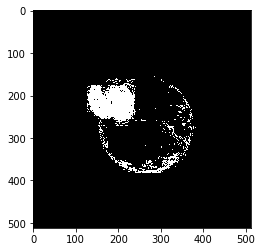

In [64]:
diff_img= np.sum((edited_image-origin_image)**2, axis=-1)

# diff_img = edited_image-origin_image

ones = np.ones_like(diff_img)
zeros = np.zeros_like(diff_img)

# diff_img = np.equal(diff_img, 0).astype(np.uint8)
edited_area = np.where(diff_img<40, zeros, ones).astype(np.uint8)

# edited_area0 = np.equal(diff, 0.).astype(np.uint8)

# edited_positions = np.argwhere(diff)

# edited_area = np.where(diff_img==0, zeros, ones).astype(np.uint8)*255

# from skimage.morphology import dilation, erosion, disk, closing, opening


# kernel = disk(4)
# closed_edited_area = opening(edited_area, kernel)

# # kernel = disk(3)
# # closed_edited_area = closing(closed_edited_area, kernel)

# kernel = disk(6)
# closed_edited_area = closing(closed_edited_area, kernel)


import matplotlib.pyplot as plt
plt.imshow(edited_area, cmap='gray')

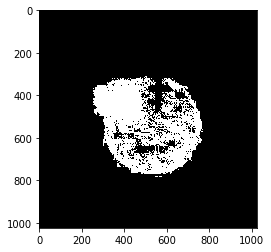

In [16]:
plt.imshow(edited_area, cmap='gray')

In [215]:
edited_positions.shape

(35068, 2)

In [216]:
tmp = []
h, w = 1024, 1024

diff_img = np.zeros((h, w))
for i in range(edited_image.shape[0]):
    for j in range(edited_image.shape[1]):
        if (edited_image[i,j,:] == origin_image[i,j,:]).all():
            diff_img[i,j] = 1
        else:
            tmp.append([i,j])

tmp = np.array(tmp)

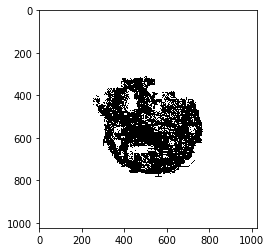

In [ ]:
plt.imshow(diff_img, cmap='gray')

In [ ]:
edited_image-origin_image

Array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
edited_area

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [159]:
np.argwhere(origin_image - edited_image!=zeros)

/data1/sr/anaconda3/envs/PhySG/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([], shape=(1, 0), dtype=int64)

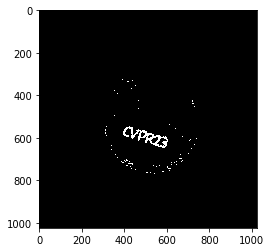

In [100]:
edited_image = imageio.imread('/data1/sr/code/PhySG/cvpr23/kitty/texture_pink.jpg')[:, :, :3]
origin_image = imageio.imread('/data1/sr/code/PhySG/cvpr23/kitty/origin_image.jpg')[:, :, :3]

diff_img= np.sum((edited_image-origin_image)**2, axis=-1)

# diff_img = edited_image-origin_image

ones = np.ones_like(diff_img)
zeros = np.zeros_like(diff_img)

# diff_img = np.equal(diff_img, 0).astype(np.uint8)
# edited_area = np.where(diff_img<110, zeros, ones).astype(np.uint8)
edited_area = np.where(diff_img<104, zeros, ones).astype(np.uint8)


# edited_area0 = np.equal(diff, 0.).astype(np.uint8)

# edited_positions = np.argwhere(diff)

# edited_area = np.where(diff_img==0, zeros, ones).astype(np.uint8)*255

import matplotlib.pyplot as plt
plt.imshow(edited_area, cmap='gray')

In [101]:
from skimage.morphology import dilation, erosion, disk, closing, opening


kernel = disk(2)
closed_edited_area = opening(edited_area, kernel)

# kernel = disk(3)
# closed_edited_area = closing(closed_edited_area, kernel)

kernel = disk(2)
closed_edited_area = closing(closed_edited_area, kernel)

# edited_area0 = np.equal(diff, 0.).astype(np.uint8)

# edited_positions = np.argwhere(diff)

# edited_area = np.where(diff_img==0, zeros, ones).astype(np.uint8)*255

import matplotlib.pyplot as plt
# plt.imshow(closed_edited_area, cmap='gray')

plt.imsave('/data1/sr/code/PhySG/cvpr23/kitty/edited_area.png', closed_edited_area, cmap='gray')

In [236]:
a = torch.tensor([5,7])
b = torch.tensor([1,2,3,4,6])

c = torch.cat((a, b), dim=0)

srt1, idx = c.sort(dim=0)
srt2, rank = idx.sort(dim=0)

a_idx = rank[:a.shape[0]]
b_idx = rank[a.shape[0]:]

a_idx, b_idx

(tensor([4, 6]), tensor([0, 1, 2, 3, 5]))

In [237]:
c.shape

torch.Size([7])

In [232]:
srt1, idx = c.sort(dim=0)

In [233]:
idx

tensor([2, 3, 4, 5, 0, 6, 1])

In [234]:
srt2, rank = idx.sort(dim=0)

In [235]:
rank

tensor([4, 6, 0, 1, 2, 3, 5])

In [1]:
import torch
import numpy as np

In [10]:
a = np.array([[1,0,0], [0,3,0]]).astype(np.float32)
b = np.array([[0,0,0], [1,1,1]]).astype(np.float32)

In [11]:
a = torch.tensor(a)
b = torch.tensor(b)

In [12]:
torch.cdist(a, b)

tensor([[1.0000, 1.4142],
        [3.0000, 2.4495]])

In [22]:
a = np.random.uniform(size=(50000, 3)).astype(np.float32)
b = np.random.uniform(size=(30000, 3)).astype(np.float32)

a = torch.tensor(a).cuda()
b = torch.tensor(b).cuda()

distance = torch.cdist(a, b)

In [23]:
distance.shape

torch.Size([50000, 30000])

In [25]:
vals, idxs = torch.min(distance, 1)

In [27]:
vals.shape, idxs.shape

(torch.Size([50000]), torch.Size([50000]))

In [28]:
vals

tensor([0.0170, 0.0299, 0.0177,  ..., 0.0131, 0.0112, 0.0283], device='cuda:0')

In [29]:
threshold = 0.02

In [31]:
edited_idx = vals<threshold

In [32]:
edited_idx

tensor([ True, False,  True,  ...,  True,  True, False], device='cuda:0')

In [37]:
differentiable_surface_points = torch.tensor(np.random.uniform(size=(50000, 3)))

In [39]:
differentiable_surface_points[edited_idx].shape

torch.Size([31038, 3])

In [40]:
~edited_idx

tensor([False,  True, False,  ..., False, False,  True], device='cuda:0')

In [41]:
edited_idx * ~edited_idx

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [42]:
unedited_pixels_idx = np.argwhere(edited_idx.cpu().numpy()==False).squeeze(-1)
unedited_pixels_idx = torch.tensor(unedited_pixels_idx)

In [43]:
unedited_pixels_idx

tensor([    1,     3,     4,  ..., 49992, 49993, 49999])

In [44]:
unedited_pixels_idx = np.argwhere(~edited_idx.cpu().numpy()==False).squeeze(-1)
unedited_pixels_idx = torch.tensor(unedited_pixels_idx)
unedited_pixels_idx

tensor([    0,     2,     6,  ..., 49996, 49997, 49998])